In [1]:
import sys
sys.path.append("../lropy")

%load_ext autoreload
%autoreload complete

In [2]:
from pathlib import Path
from datetime import datetime, timedelta, timezone
from math import factorial
import itertools
import warnings

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullLocator, FixedLocator
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
from skimage.io import imread

In [3]:
from lropy.analysis.io import load_pickled_simulation_results
from lropy.analysis.io import pos_names, vel_names, acc_names, irr_names, panels_count_names
from lropy.analysis.plotting import format_plot, save_plot
from lropy.analysis.util import get_revolutions_index, get_day_index, trim_df, get_closest_before, get_closest_after
from lropy.analysis.transform import cart2spher, spher2cart, align_vectors
from lropy.analysis.spice_tools import get_distance, get_lro_beta_angle, as_et
from lropy.constants import JULIAN_DAY, moon_polar_radius, earth_equatorial_radius, c, lro_period, astronomical_unit
from lropy.analysis.maps import moon_globe

In [4]:
def get_orbit_start(n_orbit):
    # 83 min to start opposite of subsolar point
    return pd.to_datetime(datetime(2010, 9, 26, 6) + timedelta(minutes=n_orbit*113) + timedelta(minutes=83), utc=True)

In [5]:
def get_orbit_number(time):
    time -= get_orbit_start(0)
    return (time.days * JULIAN_DAY + time.seconds) / lro_period

In [6]:
orbit_steps = int(lro_period / 5)
variable_columns = [
    "simulation_start", "use_solar_radiation", "use_moon_radiation", "target_type", "albedo_distribution_moon", "use_occultation"
]

plots_folder = "../paper/figures/plots"
tables_folder = "../paper/tables"

# Orbit geometry

Sun: 6.076454611252484e-08
Moon: 2.2923204712007033e-08


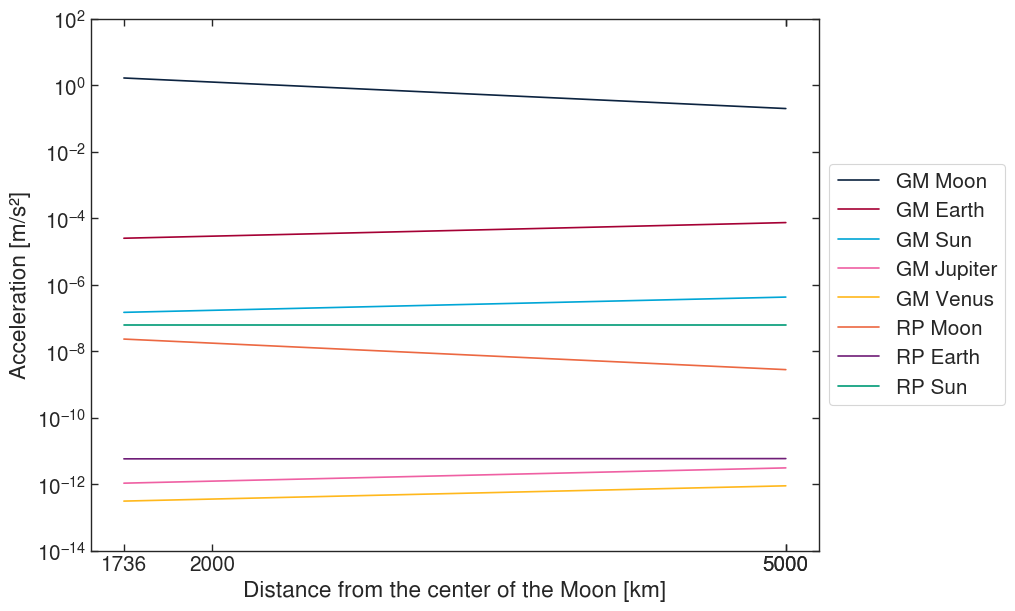

In [7]:
def plot_all_accelerations_magnitude():
    def grav_central(body, r, r_moon=None):
        gm = {
            "earth": 0.39860e6,
            "sun": 132712e6,
            "moon": 0.00490e6,
            "jupiter": 126.687e6,
            "venus": 0.32486e6
        }[body]  # km^3/s^2
    
        if body == "moon":
            # Regular central gravity
            return  gm / r**2 * 1e3
        else:
            # Perturbation
            return 2 * gm * r_moon / r**3 * 1e3
    
    # def grav_higher_order(n, m, r):
    #     def normalization_coeff(n, m):
    #         delta = 1 if m == 0 else 0
    #         return np.sqrt(factorial(n + m) / ((2 - delta) * (2*n + 1) * factorial(n - m)))
        
    #     J = {
    #         (2, 0): 9.088,
    #         (2, 2): 3.467e-5 + 9.079e-10,
    #     }[(n, m)] / normalization_coeff(n, m)
    #     return 0.00490e9 * 1738 ** n / r ** (n+2) * J

    def rp(body, r):
        A_m_Cp = 14.0 / 1087 * 1.0  # m^2/kg
        sun_luminosity = 3.828e26  # W

        if body == "sun":
            solar_irradiance = sun_luminosity / (4 * np.pi * r**2) / 1e6
            return A_m_Cp * solar_irradiance / c
        elif body == "moon":
            solar_irradiance = sun_luminosity / (4 * np.pi * r_moon_sun**2) / 1e6
            acc_rp_sun = A_m_Cp * solar_irradiance / c
            albedo = 0.15 / 2 * (moon_polar_radius/1e3 / r)**2 * acc_rp_sun
            moon_thermal_irr = 900  # somewhat arbitrary average from Lemoine 2013, but order of magnitude not very sensitive to exact value
            thermal = 0.95 / 2 * A_m_Cp * moon_thermal_irr / c * (moon_polar_radius/1e3 / r)**2
            return albedo + thermal
        elif body == "earth":
            solar_irradiance = sun_luminosity / (4 * np.pi * r_earth_sun**2) / 1e6
            acc_rp_sun = A_m_Cp * solar_irradiance / c
            return (0.34 / 2 + 0.68 / 4) * (earth_equatorial_radius/1e3 / r)**2 * acc_rp_sun
    
    r_moon_earth = 384400
    r_moon_sun = 146757375
    r_moon_jupiter = 744857858
    r_moon_venus = 154196622
    r_earth_sun = r_moon_sun

    rr_moon = np.linspace(moon_polar_radius / 1e3, 5e3, 20)  # km
    rr_earth = r_moon_earth - rr_moon
    rr_sun = r_moon_sun -rr_moon
    rr_jupiter = r_moon_jupiter - rr_moon
    rr_venus = r_moon_venus - rr_moon

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(rr_moon, grav_central("moon", rr_moon), label="GM Moon")
    ax.plot(rr_moon, grav_central("earth", rr_earth, rr_moon), label="GM Earth")
    ax.plot(rr_moon, grav_central("sun", rr_sun, rr_moon), label="GM Sun")
    ax.plot(rr_moon, grav_central("jupiter", rr_jupiter, rr_moon), label="GM Jupiter")
    ax.plot(rr_moon, grav_central("venus", rr_venus, rr_moon), label="GM Venus")

    ax.plot(rr_moon, rp("moon", rr_moon), label="RP Moon")
    ax.plot(rr_moon, rp("earth", rr_earth), label="RP Earth")
    ax.plot(rr_moon, rp("sun", rr_sun), label="RP Sun")
    print("Sun:", rp("sun", rr_sun)[0])
    print("Moon:", rp("moon", rr_moon)[0])

    ax.set_xlabel("Distance from the center of the Moon [km]")
    ax.set_ylabel("Acceleration [m/s²]")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim([1e-14, 1e2])
    # ax.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    format_plot(x_major_locator=FixedLocator([rr_moon[0], 2e3, 5e3, rr_moon[-1]]), x_minor_locator=NullLocator())
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plot_all_accelerations_magnitude()

Want to only consider accelerations much larger than RP which significantly determine orbit over 2.5 day arc.

# Lunar models

In [8]:
def tf_mosaic(dist):
    dist = dist.astype(np.double)
    dist -= 1
    dist /= 255
    dist = dist * (0.5 - 0.048) + 0.048
    return dist

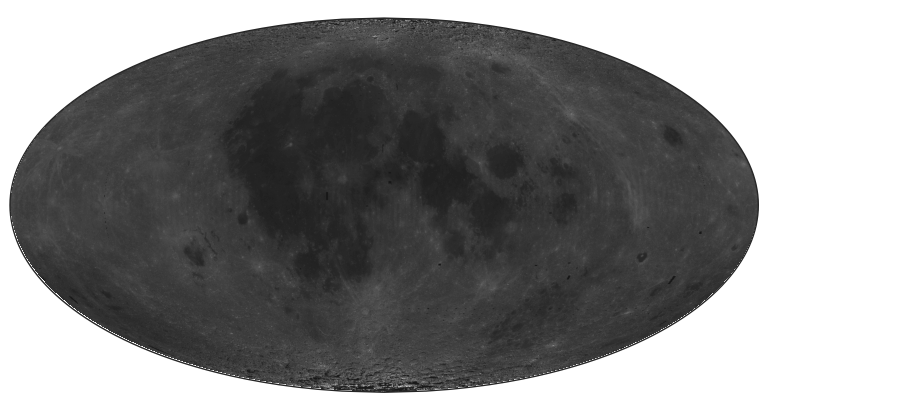

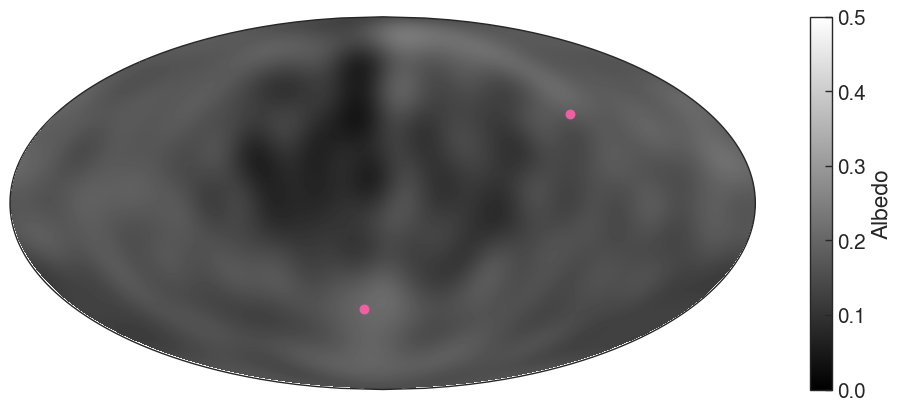

In [9]:
def plot_albedo_map():
    fig = plt.figure(figsize=(9, 4), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[7, 0.92], wspace=0.1) 
    ax = fig.add_subplot(gs[0], projection=ccrs.Mollweide(globe=moon_globe))
    cax = fig.add_subplot(gs[1])
    dist = tf_mosaic(imread("files/albedo.jpg"))
    
    ax.imshow(dist, transform=ccrs.PlateCarree(globe=moon_globe), extent=(-180, 180, -90, 90), cmap="gray", vmin=0, vmax=0.5)
    # ax.gridlines(draw_labels=["bottom", "left"], crs=ccrs.PlateCarree(globe=moon_globe))
    cax.set_axis_off()
    save_plot(plots_folder, "lunar_map_photo")

    fig = plt.figure(figsize=(9, 4), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[7, 0.2], wspace=0.1) 
    ax = fig.add_subplot(gs[0], projection=ccrs.Mollweide(globe=moon_globe))
    cax = fig.add_subplot(gs[1])
    dist = np.load("../private/dlam1.npy")
    im = ax.imshow(dist, transform=ccrs.PlateCarree(globe=moon_globe), extent=(-180, 180, -90, 90), cmap="gray", vmin=0, vmax=0.5)
    fig.colorbar(im, cax=cax, label="Albedo", use_gridspec=True)
    ax.scatter([-11, 103], [-43, 36], marker="o", c="C3", s=40, transform=ccrs.PlateCarree(globe=moon_globe))
    save_plot(plots_folder, "lunar_map_dlam1")
    
plot_albedo_map()

0.04622745098039216 0.4982274509803922 0.1208333306632689 0.11890196078431373 0.2890666666666667
0.043116665357974475 0.23649248438719175 0.15361859395452387 0.15550402250567819 0.21763279392080914


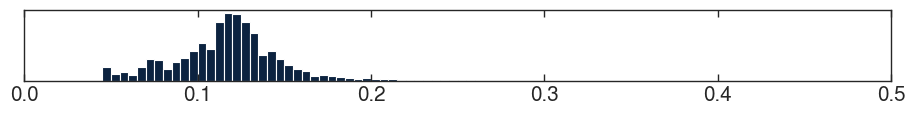

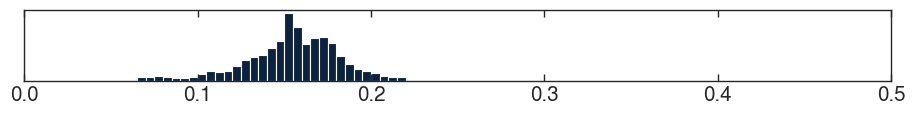

In [10]:
def plot_albedo_histogram(dist, file):
    fig, ax = plt.subplots(figsize=(9, 1))

    print(dist.min(), dist.max(), dist.mean(), np.median(dist), np.percentile(dist, 99))

    ax.hist(dist.flatten(), bins=100, density=True, range=[0, 0.5])
    # ax.set_xlabel("Albedo")
    ax.set_xlim([0, 0.5])
    ax.get_yaxis().set_visible(False)

    format_plot()
    save_plot(plots_folder, file)
    
plot_albedo_histogram(tf_mosaic(imread("files/albedo.jpg")), "lunar_hist_photo")
plot_albedo_histogram(np.load("../private/dlam1.npy"), "lunar_hist_dlam1")

0.1208333306632689


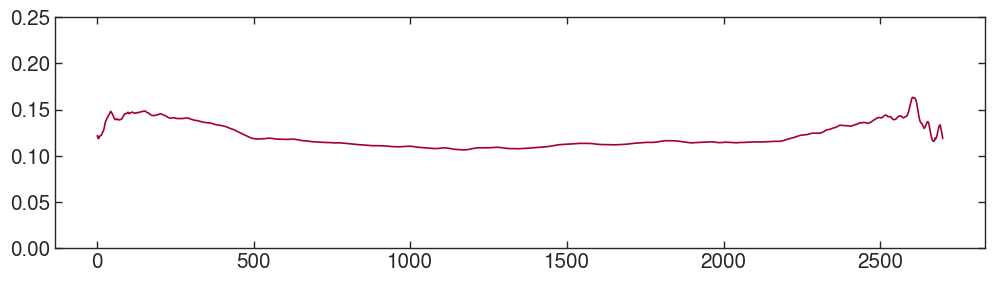

In [11]:
def plot_longitudinal_distribution():
    dist = tf_mosaic(imread("files/albedo.jpg"))

    # dist = dist[::5, ::5]
    # plt.scatter(list(range(dist.shape[0])) * dist.shape[1], dist.flatten(), s=1, alpha=0.1)

    print(np.mean(dist.flatten()))
    mean = dist.mean(axis=1)
    N = int(dist.shape[1] / 180)
    mean = np.convolve(mean, np.ones(N)/N, mode='valid')
    # mean = np.histogram(mean, np.arange(0, 180), weights=mean)[0] / np.histogram(mean, np.arange(0, 180), )[0]

    plt.plot(mean, c="C1")
    plt.ylim([0, 0.25])

plot_longitudinal_distribution()

5.670374419
1245.8181527278637


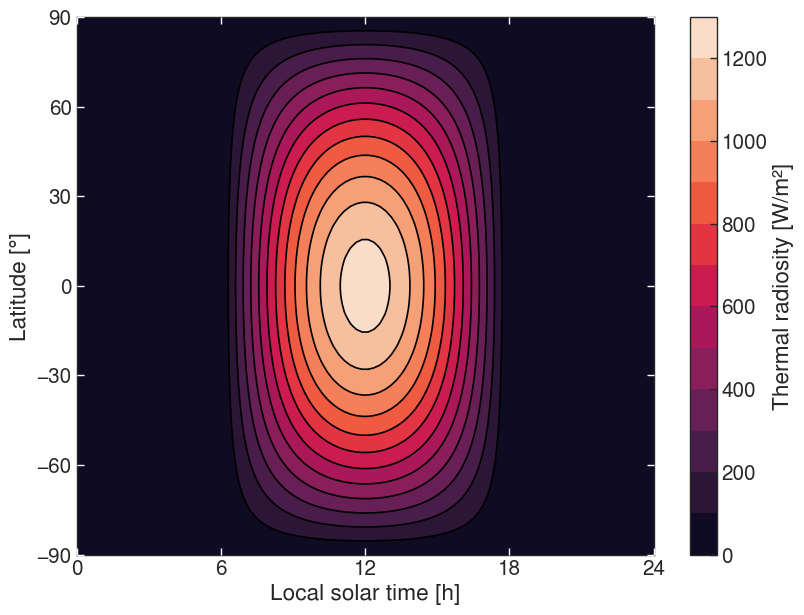

In [12]:
def thermal_radiation(polar, azimuth):
        subsolar = np.array([1, 0, 0])
        normal = np.array([
            np.cos(azimuth) * np.sin(polar),
            np.sin(azimuth) * np.sin(polar),
            np.cos(polar)
        ])
        cosphi = max(0, subsolar @ normal)
        
        sigma = 5.670374419e-8
        T = max(385 * cosphi**(1/4), 100)
        return sigma * T**4

def plot_thermal_lemoine():
    # Recreate Fig. 5 from Lemoine 2013
    polarlist = np.linspace(0, 1, 100) * np.pi
    azimuthlist = np.linspace(-1, 1, 100) * np.pi
    polars, azimuths = np.meshgrid(polarlist, azimuthlist)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    exitances = np.vectorize(thermal_radiation)(polars, azimuths)
    im = ax.contourf((azimuths / np.pi + 1) * 12, 90 - np.degrees(polars), exitances, levels=12)
    ax.contour((azimuths / np.pi + 1) * 12, 90 - np.degrees(polars), exitances, levels=12, colors="black")
    cb = fig.colorbar(im, ax=ax, label=r"Thermal radiosity [W/m²]")

    ax.set_xlabel("Local solar time [h]")
    ax.set_ylabel("Latitude [°]")
    ax.tick_params(color="white")

    cb.ax.yaxis.tick_right()

    format_plot(
        x_major_locator=FixedLocator([0, 6, 12, 18, 24]),
        y_major_locator=FixedLocator(range(-90, 91, 30)),
    )
    save_plot(plots_folder, "thermal_map")
    
plot_thermal_lemoine()
print(thermal_radiation(0, 0))
print(thermal_radiation(np.pi / 2, 0))

# Paneling

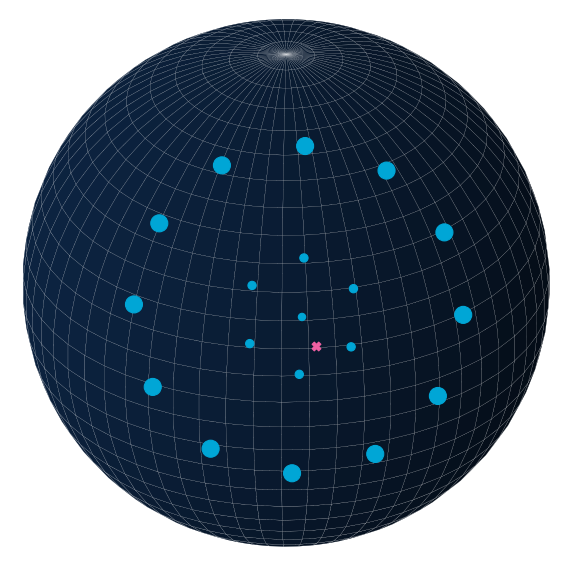

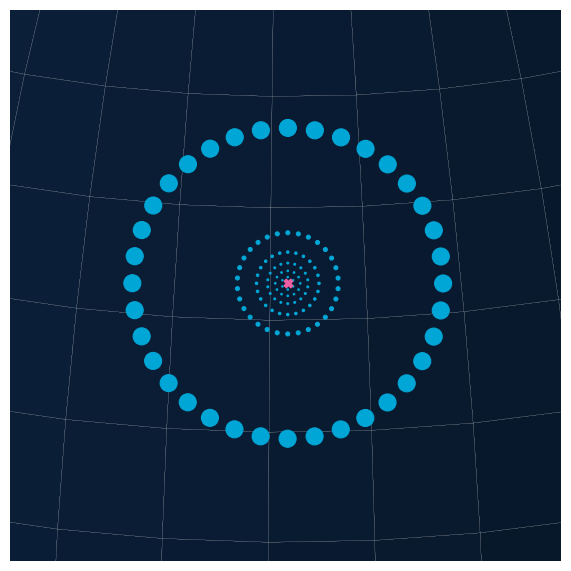

In [13]:
def calculate_cap_polar_angle(h, planet_radius):
    return np.arccos(planet_radius / (h + planet_radius))

def generate_panels_knocke(pos, n_panels_per_ring: list[int], R_e):
    # Initialize with central cap
    polars = [0]
    azimuths = [0]
    areas_from_geometry = []

    N = 1 + sum(n_panels_per_ring)

    r_s = np.linalg.norm(pos)

    zeta_m = np.arcsin(R_e / r_s)
    zeta_1 = np.arccos((N - 1 + np.cos(zeta_m)) / N)
    gamma_1 = np.arcsin(r_s * np.sin(zeta_1) / R_e)
    betas = [gamma_1 - zeta_1]

    area_central_cap = 2 * np.pi * R_e**2 * (1 - np.cos(betas[0]))
    areas_from_geometry.append(area_central_cap)

    k = 1
    for N_s in n_panels_per_ring:
        k += N_s
        zeta_i = np.arccos(k * np.cos(zeta_1) - k + 1)
        # gamma_i = np.arcsin(r_s * np.sin(zeta_i) / R_e)
        gamma_i = np.arcsin(min(1.0, r_s * np.sin(zeta_i) / R_e))
        betas.append(gamma_i - zeta_i)

        azimuths.extend(np.linspace(0, 2 * np.pi, N_s + 1)[:-1])

    for N_s, lower, upper in zip(n_panels_per_ring, betas[:-1], betas[1:]):
        beta_star = (lower + upper) / 2
        polars.extend([beta_star] * N_s)

        # Area from actual area on sphere
        areas_from_geometry.extend([2 * np.pi * R_e**2 * (np.cos(lower) - np.cos(upper)) / N_s] * N_s)

    assert len(polars) == len(areas_from_geometry)
    assert len(polars) == len(azimuths)
    assert len(polars) == sum(n_panels_per_ring) + 1

    rotation = align_vectors(np.array([0, 0, 1]), pos)
    polars_rotated = []
    azimuths_rotated = []

    for polar, azimuth in zip(polars, azimuths):
        coords_cartesian = spher2cart(R_e, polar, azimuth)
        # coords_cartesian_target_centric = rotation.apply(coords_cartesian)
        coords_cartesian_target_centric = rotation @ coords_cartesian
        coords_spherical_target_centric = cart2spher(*coords_cartesian_target_centric)
        polars_rotated.append(coords_spherical_target_centric[1] % (np.pi))
        azimuths_rotated.append(coords_spherical_target_centric[2] % (2 * np.pi))
    
    return polars_rotated, azimuths_rotated, np.array(areas_from_geometry)

def plot_dynamically_paneled_sphere(fig, ax, n_panels_per_ring: list[int], h, pos, zoom):
    pos = np.array(pos)

    radius = moon_polar_radius / 1e3

    altitude = radius + h
    pos = pos / np.linalg.norm(pos) * altitude

    azimuths, polars = np.mgrid[0:2*np.pi:60j, 0:np.pi:30j]

    ax.plot_surface(*spher2cart(radius*0.99, polars, azimuths), alpha=1, linewidth=0.1, rasterized=True, rcount=1000, ccount=1000)
    
    panels = generate_panels_knocke(pos, n_panels_per_ring, radius)
    ax.scatter(*spher2cart(radius, *panels[:-1]), c="C2", label="panels", s=150 * panels[-1] / panels[-1].max(), depthshade=False)
    
    ax.scatter(*pos, marker="X", c="C3", s=40, label="spacecraft")

    # Nadir vector
    # ax.plot(*np.array([pos, pos / np.linalg.norm(pos) * radius]).T, c="white")

    # Draw circle of visible region
    cap_polar = calculate_cap_polar_angle(h, radius)
    rotation = align_vectors(np.array([0, 0, 1]), pos)
    visible_region = np.zeros((100, 3))

    for i, azimuth in enumerate(np.linspace(0, 2*np.pi, 100)):
        visible_region[i, :] = rotation @ np.array(spher2cart(radius, cap_polar, azimuth))
    ax.plot(*visible_region.T, c="C1", label="visible latitude")
    
    lim = radius * zoom
    ax.set_xlim([-lim*0.9, lim])
    ax.set_ylim([-lim, lim])
    ax.set_zlim([-lim, lim*1.1])
    ax.set_aspect("equal")

    ax.set_axis_off()

def plot_knocke_paneling():
    def get_ax():
        return plt.subplots(figsize=[12, 6], subplot_kw={"projection": "3d", "proj_type": "ortho"}, tight_layout=True)
    
    fig, ax = get_ax()
    plot_dynamically_paneled_sphere(fig, ax, [6, 12], 1500, [2, -3, 1.5], 0.59)
    save_plot(plots_folder, "knocke_paneling_high")

    fig, ax = get_ax()
    plot_dynamically_paneled_sphere(fig, ax, [6, 12, 18, 24, 30, 36], 50, [2, -3.45, 2.3], 0.15)
    save_plot(plots_folder, "knocke_paneling_low")

plot_knocke_paneling()

1 860.946595213065 48.96501109757034
2 1152.44759226277 31.68548385140334
3 1321.42796000686 21.668705527988408
4 1424.08959885205 15.583153150755436
5 1491.93102655021 11.561665024835454
6 1539.54192644153 8.739397347492606
7 1574.47699546323 6.6685245782160845
8 1601.0067984384 5.095897184194764
9 1616.54041694608 4.175099015572192
10 1638.70957029356 2.860961180129673
11 1652.31541645328 2.054437045380497
12 1663.33526032872 1.401205343185996
13 1672.52644534687 0.856372448777043
14 1680.30911991684 0.3950329040038336
15 1686.97321921447 0.0


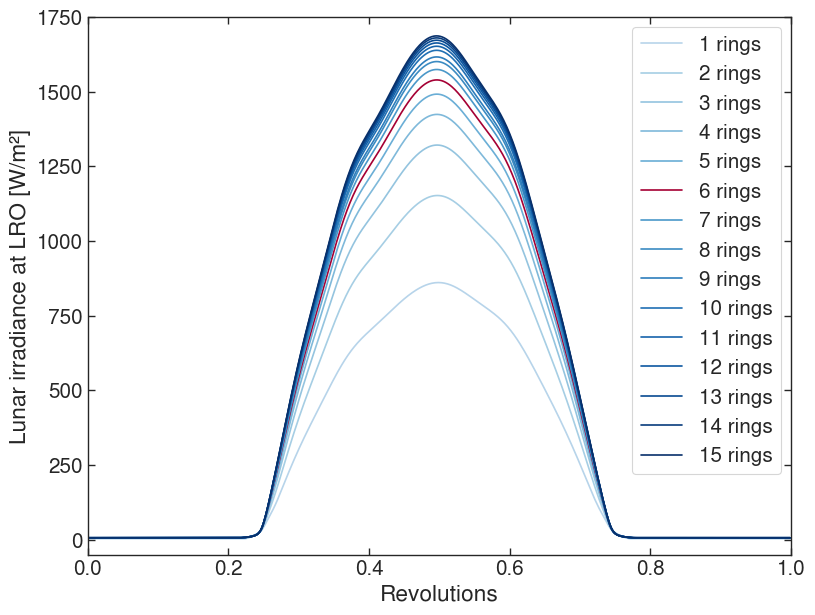

In [33]:
def plot_paneling_convergence():
    results_folder_rings = Path("../results/number_of_panels_per_ring_test-2023-08-17T14-33-31-ffcd7/")
    # results_folder_rings = Path("../results/number_of_panels_per_ring_test-2023-08-17T13-58-09-92f24/")
    metadata_rings, runs_rings = load_pickled_simulation_results(results_folder_rings)

    idxs = metadata_rings[
        (metadata_rings["albedo_distribution_moon"] == "DLAM1")
    ]
    dfs = {
        len(row.number_of_panels_per_ring_moon): runs_rings[row.Index] for row in idxs.itertuples()
    }
    dfs = dict(sorted(dfs.items(), key=lambda item: item[0]))
    dfs, labels = dfs.values(), dfs.keys()

    fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex="all")

    dfs = list(dfs)
    for i, df in enumerate(dfs):
        dfs[i] = trim_df(df, datetime(2010, 8, 26, 6, 57), datetime(2010, 8, 26, 8, 50))

    cmap = matplotlib.colormaps["Blues"](np.linspace(0.3, 1, len(dfs)))

    for df, label, color in zip(dfs, list(labels), cmap):
        if label == 6:
            color = "C1"
        print(label, df["irr_moon"].max(), abs(df["irr_moon"].max() / dfs[-1]["irr_moon"].max() - 1) * 100)
        ax.plot(get_revolutions_index(df), df["irr_moon"], label=f"{label} rings", c=color)

    ax.legend()

    ax.set_xlim([0, 1])
    ax.set_ylim([-50, 1751])
    ax.set_xlabel("Revolutions")
    ax.set_ylabel("Lunar irradiance at LRO [W/m²]")
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()
    save_plot(plots_folder, "paneling_convergence")
    
plot_paneling_convergence()

# Target model

In [99]:
def generate_target_model_table():
    panels = pd.DataFrame.from_records([
        ("+X", 0.29, 0.22, 2.82, ""),
        ("-X", 0.39, 0.19, 2.82, ""),
        ("+Y", 0.32, 0.23, 3.69, ""),
        ("-Y", 0.32, 0.18, 3.69, ""),
        ("+Z", 0.32, 0.18, 5.14, ""),
        ("-Z", 0.54, 0.18, 5.14, ""),
        ("+SA", 0.05, 0.05, 11.00, "+Sun or fixed"),
        ("-SA", 0.30, 0.20, 11.00, "-Sun or fixed"),
        ("+HGA", 0.18, 0.28, 1.00, "+Earth"),
        ("-HGA", 0.019, 0.0495, 1.00, "-Earth")
    ], columns=["Panel", "Cs", "Cd", "A", "Tracking"]).convert_dtypes()
    panels["Ca"] = 1 - panels["Cs"] - panels["Cd"]
    panels = panels[["Panel", "Ca", "Cs", "Cd", "A", "Tracking"]].rename(columns={
        "Ca": "$\mathbf C_a$",
        "Cs": "$\mathbf C_s$",
        "Cd": "$\mathbf C_d$",
        "A": r"$\mathbf A$~[\unit{\meter\squared}]",
        "Tracking": r"\bfseries Tracking"
    })

    table = (
        panels.style
        .format(precision=2)
        .applymap_index(lambda v: "font-weight: bold;", axis="columns")
        .applymap(lambda v: "font-weight: bold;", "Panel")
        .hide(axis="index")
        .to_latex(convert_css=True, hrules=True)
    )
    
    print(table)
    with open(tables_folder + "/target_model.tex", "w") as f:
        f.write(table)

generate_target_model_table()

\begin{tabular}{lrrrrl}
\toprule
\bfseries Panel & \bfseries $\mathbf C_a$ & \bfseries $\mathbf C_s$ & \bfseries $\mathbf C_d$ & \bfseries $\mathbf A$~[\unit{\meter\squared}] & \bfseries Tracking \\
\midrule
\bfseries +X & 0.49 & 0.29 & 0.22 & 2.82 &  \\
\bfseries -X & 0.42 & 0.39 & 0.19 & 2.82 &  \\
\bfseries +Y & 0.45 & 0.32 & 0.23 & 3.69 &  \\
\bfseries -Y & 0.50 & 0.32 & 0.18 & 3.69 &  \\
\bfseries +Z & 0.50 & 0.32 & 0.18 & 5.14 &  \\
\bfseries -Z & 0.28 & 0.54 & 0.18 & 5.14 &  \\
\bfseries +SA & 0.90 & 0.05 & 0.05 & 11.00 & +Sun or fixed \\
\bfseries -SA & 0.50 & 0.30 & 0.20 & 11.00 & -Sun or fixed \\
\bfseries +HGA & 0.54 & 0.18 & 0.28 & 1.00 & +Earth \\
\bfseries -HGA & 0.93 & 0.02 & 0.05 & 1.00 & -Earth \\
\bottomrule
\end{tabular}



In [16]:
def load_mass_history():
    def parse_line(line):
        date = pd.to_datetime(line[56:73], format="%Y %j %H:%M:%S", utc=True)
        fuel_mass = float(line[104:111])
        return date, fuel_mass

    dry_mass = 1020.9
    history = []
    for f in Path("files/lro_sff").glob("*.txt"):
        line_start, line_stop, _, line_avg = f.open().readlines()[2:6]
        average_mass = float(line_avg[103:111])
        history.append(parse_line(line_start) + (average_mass,))
        history.append(parse_line(line_stop) + (average_mass,))
    
    history = pd.DataFrame(history, columns=["date", "fuel_mass", "average_mass"]).set_index("date").sort_index()
    history["mass"] = dry_mass + history["fuel_mass"]
    return history

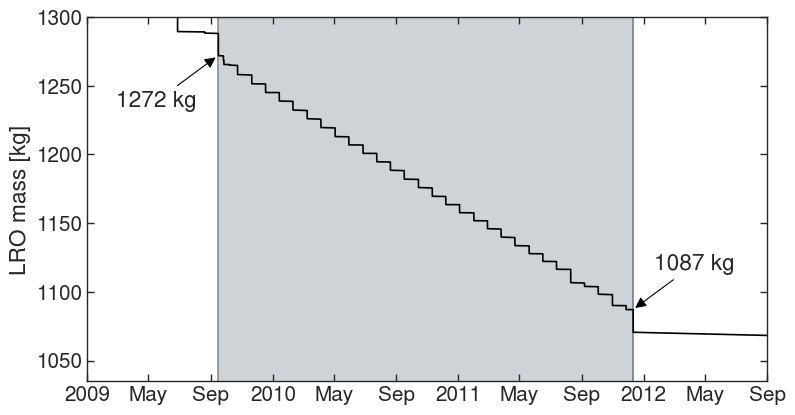

In [102]:
def plot_mass_history():
    mass_history = load_mass_history()

    fig, ax = plt.subplots(figsize=(8, 4))

    ax.axvline(datetime(2009, 9, 16), alpha=0.5)  # actually September 15
    ax.axvline(datetime(2011, 12, 11), alpha=0.5)  # actually December 11
    ax.axvspan(datetime(2009, 9, 16), datetime(2011, 12, 11), alpha=0.2)

    # ax.annotate("LRO science mission", (datetime(2009, 9, 15), 1350), xytext=(5, -5), textcoords="offset points", va="top")

    start_mass = get_closest_before(mass_history, datetime(2009, 9, 16, tzinfo=timezone.utc))["mass"]
    ax.annotate(
        f"{start_mass:.0f} kg",
        (datetime(2009, 9, 15), start_mass),
        xytext=(-15, -25),
        va="top",
        ha="right",
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black")
    )

    end_mass = get_closest_after(mass_history, datetime(2011, 12, 10, tzinfo=timezone.utc))["mass"]
    ax.annotate(
        f"{end_mass:.0f} kg",
        (datetime(2011, 12, 11), end_mass),
        xytext=(15, 25),
        va="bottom",
        ha="left",
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black")
    )

    ax.plot(mass_history.index, mass_history["mass"], color="black")

    # ax.set_xlabel("Date")
    ax.set_ylabel("LRO mass [kg]")
    ax.set_xlim([datetime(2009, 1, 1), datetime(2012, 9, 1)])
    ax.set_ylim([1035, 1300])

    # ax.set_xticklabels(ax.get_xticklabels())

    format_plot(x_major_locator=matplotlib.dates.AutoDateLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    save_plot(plots_folder, "mass_history")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_mass_history()

# Performance benchmark

In [53]:
metadata_benchmark = load_pickled_simulation_results("../results/full-benchmark-2023-08-17T15-23-23-792e0")
# metadata_benchmark = load_pickled_simulation_results("../results/full-benchmark-2023-08-09T22-29-06-0588e")
# metadata_benchmark = load_pickled_simulation_results("../results/full-benchmark-2023-08-09T17-19-02-c2fa1")
metadata_benchmark = metadata_benchmark[variable_columns + ["walltime_propagation", "walltime_total"]]

In [64]:
# Average over dates
metadata_benchmark = metadata_benchmark\
    .groupby(list(set(variable_columns) - set(["simulation_start"])))\
    .agg({"walltime_propagation": "mean", "walltime_total": "sum"})\
    .reset_index()
metadata_benchmark

,use_solar_radiation,use_moon_radiation,use_occultation,albedo_distribution_moon,target_type,walltime_propagation,walltime_total
0,False,False,False,,Cannonball,291.681685,"[303.7969672717154, 293.06312930583954, 291.52..."
1,False,True,False,Constant,Cannonball,331.874746,"[332.98206165619195, 340.2291926499456, 335.94..."
2,False,True,False,Constant,Paneled,370.908604,"[356.2365205530077, 359.82075977884233, 356.78..."
3,False,True,False,DLAM1,Cannonball,562.665682,"[566.947464466095, 568.5207856371999, 563.0490..."
4,False,True,False,DLAM1,Paneled,581.347984,"[584.2942981291562, 585.4188827462494, 584.258..."
5,False,True,True,Constant,Cannonball,340.642557,"[343.9158656001091, 368.4750501550734, 345.401..."
6,False,True,True,Constant,Paneled,362.972287,"[359.60756540857255, 362.85488280281425, 362.7..."
7,False,True,True,DLAM1,Cannonball,565.810178,"[570.4475996606052, 573.2736935969442, 568.258..."
8,False,True,True,DLAM1,Paneled,578.860311,"[590.701100628823, 592.2468180283904, 587.5016..."
9,True,False,False,,Cannonball,294.19019,"[303.42368713207543, 292.975547272712, 294.903..."


In [55]:
def get_benchmark_times(use_solar, use_lunar, target_type, albedo, use_occultation):
    df = metadata_benchmark[
        (metadata_benchmark["use_solar_radiation"] == use_solar) &
        (metadata_benchmark["use_moon_radiation"] == use_lunar) &
        (metadata_benchmark["target_type"] == target_type) &
        (metadata_benchmark["albedo_distribution_moon"] == albedo) &
        (metadata_benchmark["use_occultation"] == use_occultation)
    ]
    if len(df.index) > 1:
        raise ValueError("More than one run found")
    return np.array(df.iloc[0]["walltime_total"])

In [63]:
# fig, ax = plt.subplots()

# sns.stripplot(x=get_benchmark_times("2010 JUN 26", False, True, "Paneled", "DLAM1", True), ax=ax, label="2010 JUN 26")
# sns.stripplot(x=get_benchmark_times("2010 SEP 26", False, True, "Paneled", "DLAM1", True), ax=ax, label="2010 SEP 26")
# sns.pointplot(x=get_benchmark_times("2010 JUN 26", False, True, "Paneled", "DLAM1", True), ax=ax, label="2010 JUN 26", markers="d", ci=None)
# sns.pointplot(x=get_benchmark_times("2010 SEP 26", False, True, "Paneled", "DLAM1", True), ax=ax, label="2010 SEP 26", markers="d", ci=None)
# ax.legend()

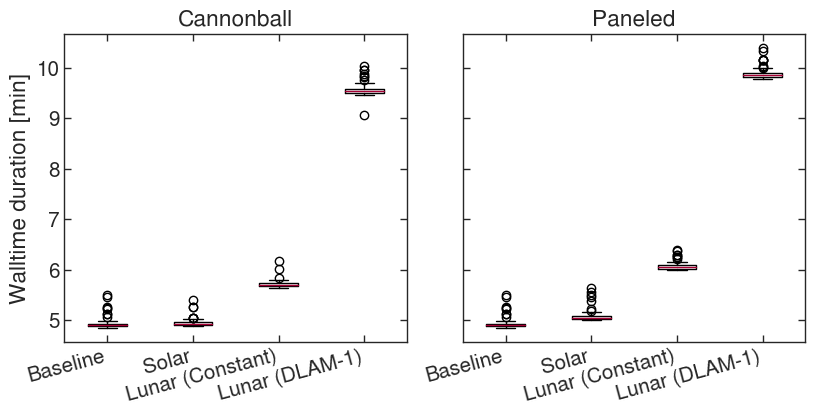

In [70]:
def plot_performance():
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey="all")
    
    for ax, target_type in zip(axs, ["Cannonball", "Paneled"]):
        times_baseline = get_benchmark_times(False, False, "Cannonball", "", False)
        times_solar = get_benchmark_times(True, False, target_type, "", True)
        times_lunar_const = get_benchmark_times(True, True, target_type, "Constant", True)
        times_lunar_dlam = get_benchmark_times(True, True, target_type, "DLAM1", True)

        ax.boxplot(
            [times_baseline / 60, times_solar / 60, times_lunar_const / 60, times_lunar_dlam / 60],
            labels=["Baseline", "Solar", "Lunar (Constant)", "Lunar (DLAM-1)"],
        )

        ax.set_xticklabels(ax.get_xticklabels(), ha="right", rotation=15)
        ax.set_title(target_type)
    
    # axs[0].set_ylim([0, max([ax.get_ylim()[1] for ax in axs])])
    
    axs[0].set_ylabel("Walltime duration [min]")

    format_plot()
    save_plot(plots_folder, "performance")

plot_performance()

# Load data

In [103]:
metadata, runs = load_pickled_simulation_results("../results/full-2023-08-18T21-29-26-19ef7")
metadata["albedo_distribution_moon"] = metadata["albedo_distribution_moon"].replace({
    "DLAM1": "DLAM-1",
    "Constant": "constant"
})

In [104]:
metadata[variable_columns]

,simulation_start,use_solar_radiation,use_moon_radiation,target_type,albedo_distribution_moon,use_occultation
1,2011 SEP 26 18:00:00,True,True,Cannonball,DLAM-1,False
2,2011 SEP 26 18:00:00,True,False,Paneled,,True
3,2011 SEP 26 18:00:00,True,True,Cannonball,constant,False
4,2011 SEP 26 18:00:00,True,False,Paneled,,False
5,2010 JUN 28 15:00:00,False,True,Paneled,constant,True
6,2010 JUN 28 15:00:00,False,True,Paneled,DLAM-1,True
7,2011 SEP 26 18:00:00,False,True,Paneled,DLAM-1,False
8,2010 JUN 28 15:00:00,True,True,Cannonball,DLAM-1,True
9,2010 JUN 28 15:00:00,False,True,Cannonball,DLAM-1,True
10,2011 SEP 26 18:00:00,False,True,Cannonball,constant,True


In [105]:
def get_baseline(start_date):
    for date in metadata["simulation_start"].unique():
        if date.startswith(start_date):
            start_date = date
            break

    df = metadata[
        (metadata["simulation_start"] == start_date) &
        (metadata["use_solar_radiation"] == False) &
        (metadata["use_moon_radiation"] == False)
    ]
    if len(df.index) > 1:
        raise ValueError("More than one run found")
    return runs[df.index[0]].copy()

In [106]:
def get_run(start_date, use_solar, use_lunar, target_type, albedo, use_occultation):
    for date in metadata["simulation_start"].unique():
        if date.startswith(start_date):
            start_date = date
            break

    df = metadata[
        (metadata["simulation_start"] == start_date) &
        (metadata["use_solar_radiation"] == use_solar) &
        (metadata["use_moon_radiation"] == use_lunar) &
        (metadata["target_type"] == target_type) &
        (metadata["albedo_distribution_moon"] == albedo) &
        (metadata["use_occultation"] == use_occultation)
    ]
    if len(df.index) > 1:
        raise ValueError("More than one run found")
    return runs[df.index[0]].copy()

# Orbit geometry

In [107]:
duration = metadata["simulation_duration"].iloc[0]
for start_date in metadata["simulation_start"].unique():
    print(start_date)
    start_date_et = as_et(start_date)
    print(" Beta", get_lro_beta_angle(start_date_et))
    print(" Sun distance", get_distance("Sun", "LRO", start_date_et) / astronomical_unit)

    end_date_et = start_date_et + duration
    print(" Beta", get_lro_beta_angle(end_date_et))
    print(" Sun distance", get_distance("Sun", "LRO", end_date_et) / astronomical_unit)

    h = get_baseline(start_date)["h"] / 1e3
    print(" Altitude range", h.min(), h.max())

    print()

2011 SEP 26 18:00:00
 Beta -1.7095639214208802
 Sun distance 1.0002599966486814
 Beta -3.5557992386268182
 Sun distance 0.9997387761189371
 Altitude range 36.6465433250766 66.21509536235591

2010 JUN 28 15:00:00
 Beta 88.88225981064335
 Sun distance 1.0190047947159588
 Beta 88.78453027686777
 Sun distance 1.0183046853123707
 Altitude range 38.3594218196825 65.5188465229967



# Accelerations

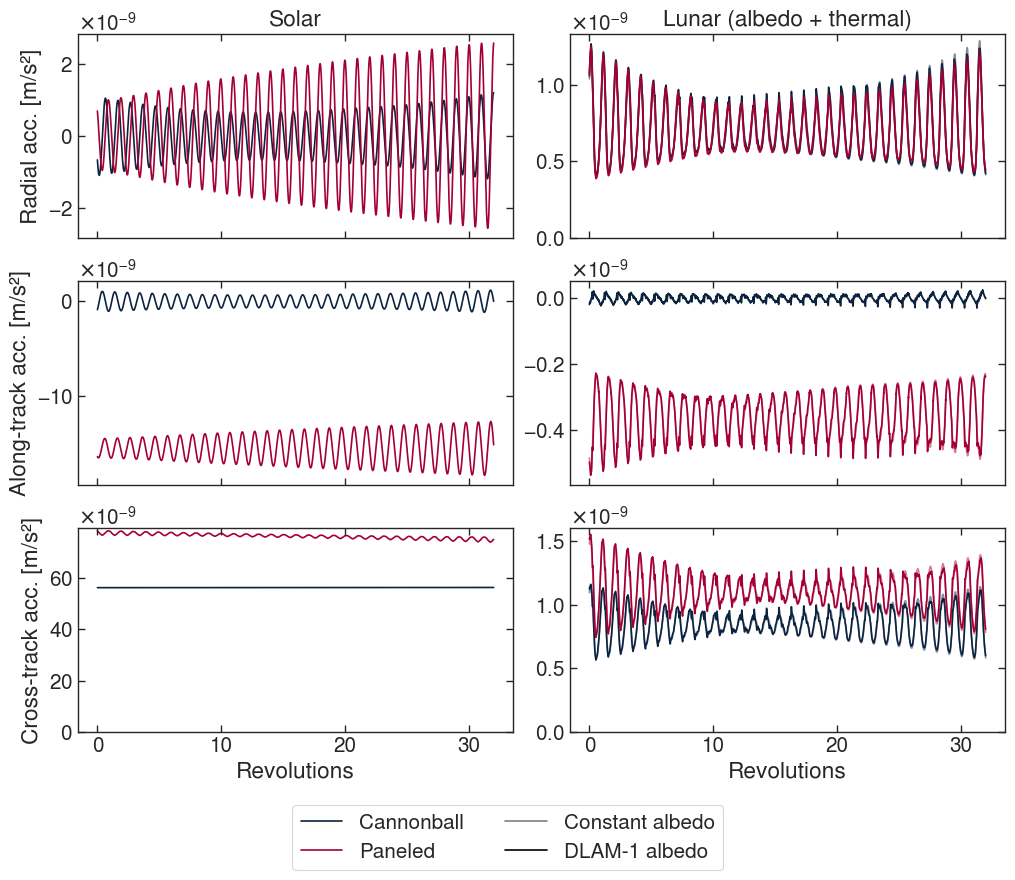

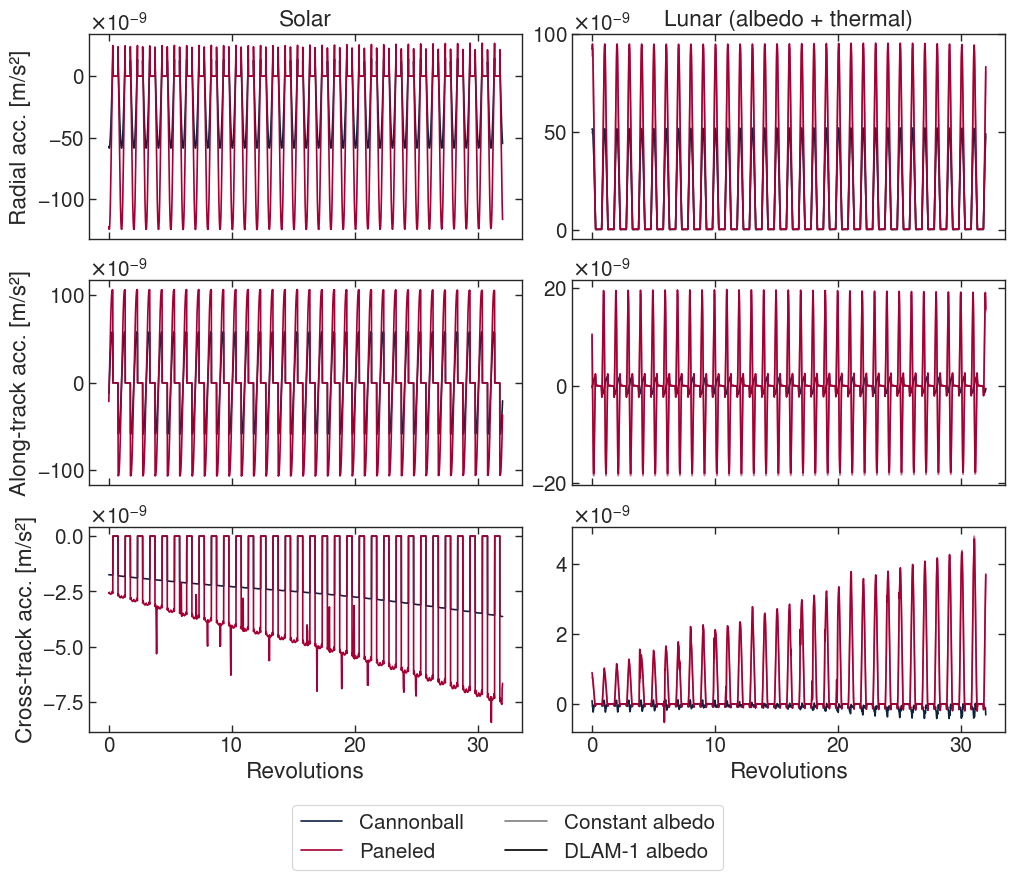

In [108]:
def plot_rp_accelerations(start_date):
    fig, axs = plt.subplots(3, 2, figsize=(10, 8), sharex="all")

    for i, (target_type, albedo_distribution_moon) in enumerate(itertools.product(["Cannonball", "Paneled"], ["constant", "DLAM-1"])):
        run = get_run(start_date, True, True, target_type, albedo_distribution_moon, True)
        time = get_revolutions_index(run)

        color = f"C{int(target_type == 'Paneled')}"
        alpha = 0.5 if albedo_distribution_moon == "constant" else 1

        # for col in run.columns:
        #     if col.startswith("acc_rp"):
        #         run[col] = run[col].rolling(orbit_steps).mean()

        if albedo_distribution_moon == "constant":
            ax_radial, ax_along, ax_cross = axs[:, 0]
            ax_radial.plot(time, run[f"acc_rp_sun_radial"], color=color)
            ax_along.plot(time, run[f"acc_rp_sun_along"], color=color)
            ax_cross.plot(time, run[f"acc_rp_sun_cross"], color=color)

        ax_radial, ax_along, ax_cross = axs[:, 1]
        ax_radial.plot(time, run[f"acc_rp_moon_radial"], alpha=alpha, color=color)
        ax_along.plot(time, run[f"acc_rp_moon_along"], alpha=alpha, color=color)
        ax_cross.plot(time, run[f"acc_rp_moon_cross"], alpha=alpha, color=color)
    
    fig.legend(
        [
            Line2D([0], [0], color="C0"),
            Line2D([0], [0], color="C1"),
            Line2D([0], [0], color="black", alpha=0.5),
            Line2D([0], [0], color="black", alpha=1),
        ],
        ["Cannonball", "Paneled", "Constant albedo", "DLAM-1 albedo"],
        bbox_to_anchor=(0.5, -0.12), loc="lower center", ncol=2)

    axs[0, 0].set_title("Solar")
    axs[0, 1].set_title("Lunar (albedo + thermal)")

    for ax in axs[-1, :].flat:
        # Last row
        # ax.set_xlim(17, 20)
        ax.set_xlabel("Revolutions")

    for ax, name in zip(axs[:, 0].flat, ["Radial", "Along-track", "Cross-track"]):
        # First column
        ax.set_ylabel(name + r" acc. [m/s²]")
    
    for ax in axs.flat:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
        ax.set_ylim([min(0, ax.get_ylim()[0]), max(0, ax.get_ylim()[1])])
    
    format_plot()
    save_plot(plots_folder, "rp_acceleration")

plot_rp_accelerations("2010 JUN 28")
plot_rp_accelerations("2011 SEP 26")
# # plot_rp_accelerations("2010 SEP 26")
# plot_rp_accelerations("2010 JUN 26")

No interesting evolution, only changes are due to slight change in beta angle.

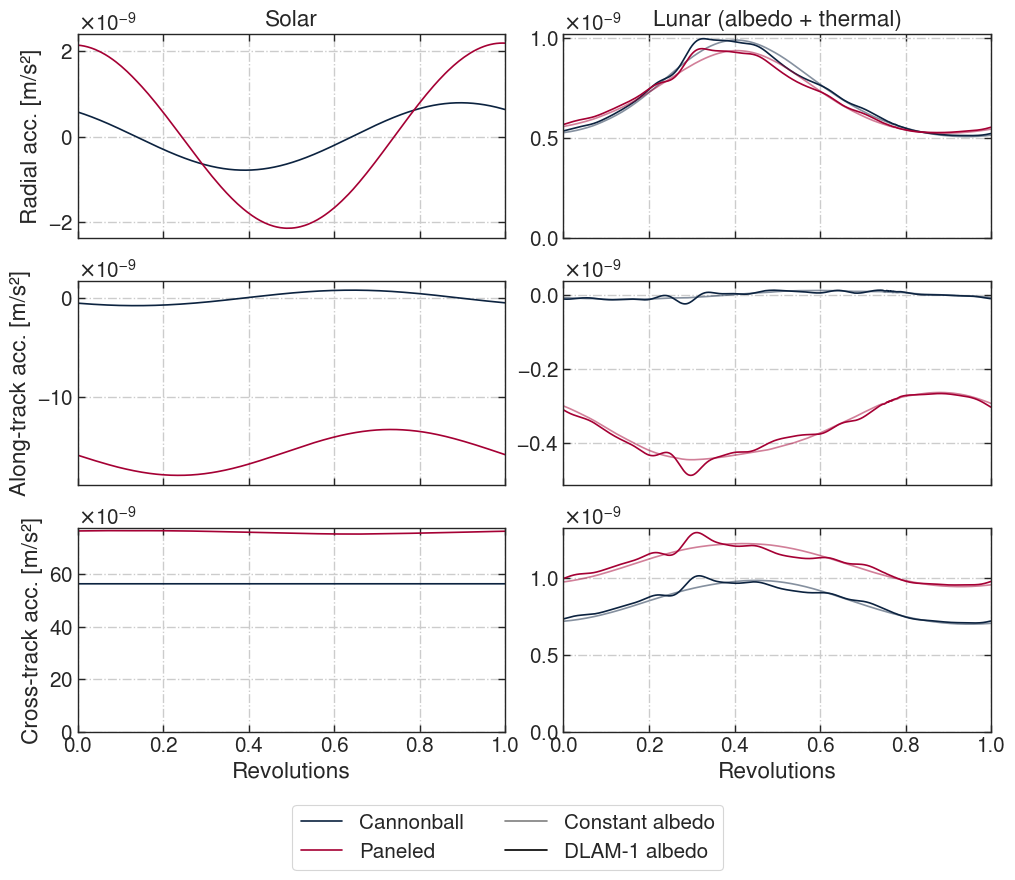

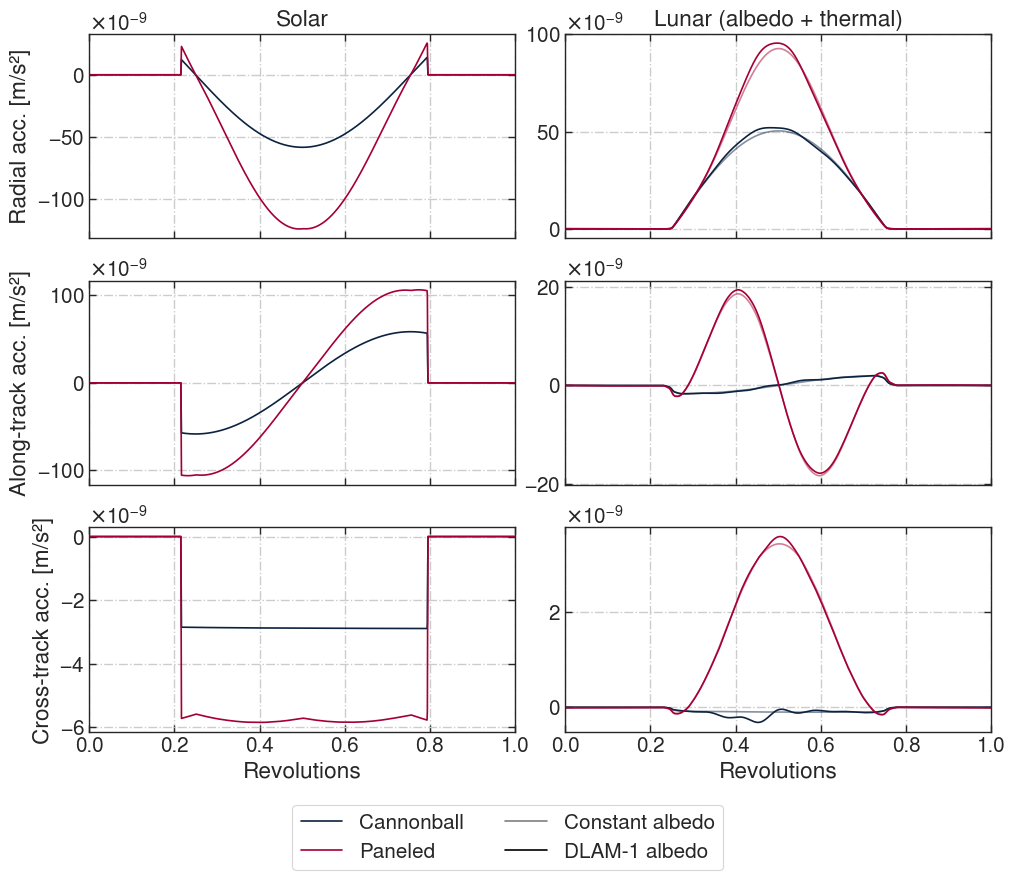

In [109]:
def plot_rp_accelerations_single_orbit(start_date, start_index):
    fig, axs = plt.subplots(3, 2, figsize=(10, 8), sharex="all")

    for i, (target_type, albedo_distribution_moon) in enumerate(itertools.product(["Cannonball", "Paneled"], ["constant", "DLAM-1"])):
        run = get_run(start_date, True, True, target_type, albedo_distribution_moon, True)
        run = run.set_index(get_revolutions_index(run))
        run = run.iloc[(run.index >= start_index) & (run.index  <= start_index + 1)]
        time = run.index - run.index[0]

        color = f"C{int(target_type == 'Paneled')}"
        alpha = 0.5 if albedo_distribution_moon == "constant" else 1

        if albedo_distribution_moon == "constant":
            ax_radial, ax_along, ax_cross = axs[:, 0]
            ax_radial.plot(time, run[f"acc_rp_sun_radial"], color=color)
            ax_along.plot(time, run[f"acc_rp_sun_along"], color=color)
            ax_cross.plot(time, run[f"acc_rp_sun_cross"], color=color)

        ax_radial, ax_along, ax_cross = axs[:, 1]
        ax_radial.plot(time, run[f"acc_rp_moon_radial"], alpha=alpha, color=color)
        ax_along.plot(time, run[f"acc_rp_moon_along"], alpha=alpha, color=color)
        ax_cross.plot(time, run[f"acc_rp_moon_cross"], alpha=alpha, color=color)
    
    fig.legend(
        [
            Line2D([0], [0], color="C0"),
            Line2D([0], [0], color="C1"),
            Line2D([0], [0], color="black", alpha=0.5),
            Line2D([0], [0], color="black", alpha=1),
        ],
        ["Cannonball", "Paneled", "Constant albedo", "DLAM-1 albedo"],
        bbox_to_anchor=(0.5, -0.12), loc="lower center", ncol=2)

    axs[0, 0].set_title("Solar")
    axs[0, 1].set_title("Lunar (albedo + thermal)")

    for ax in axs[-1, :].flat:
        # Last row
        ax.set_xlim([0, 1])
        ax.set_xlabel("Revolutions")

    for ax, name in zip(axs[:, 0].flat, ["Radial", "Along-track", "Cross-track"]):
        # First column
        ax.set_ylabel(name + r" acc. [m/s²]")
    
    for ax in axs.flat:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
        ax.set_ylim([min(0, ax.get_ylim()[0]), max(0, ax.get_ylim()[1])])
    
    format_plot(major_grid=True)
    save_plot(plots_folder, "rp_acceleration")

plot_rp_accelerations_single_orbit("2010 JUN 28", 21)
plot_rp_accelerations_single_orbit("2011 SEP 26", 21.55)

# Orbital elements

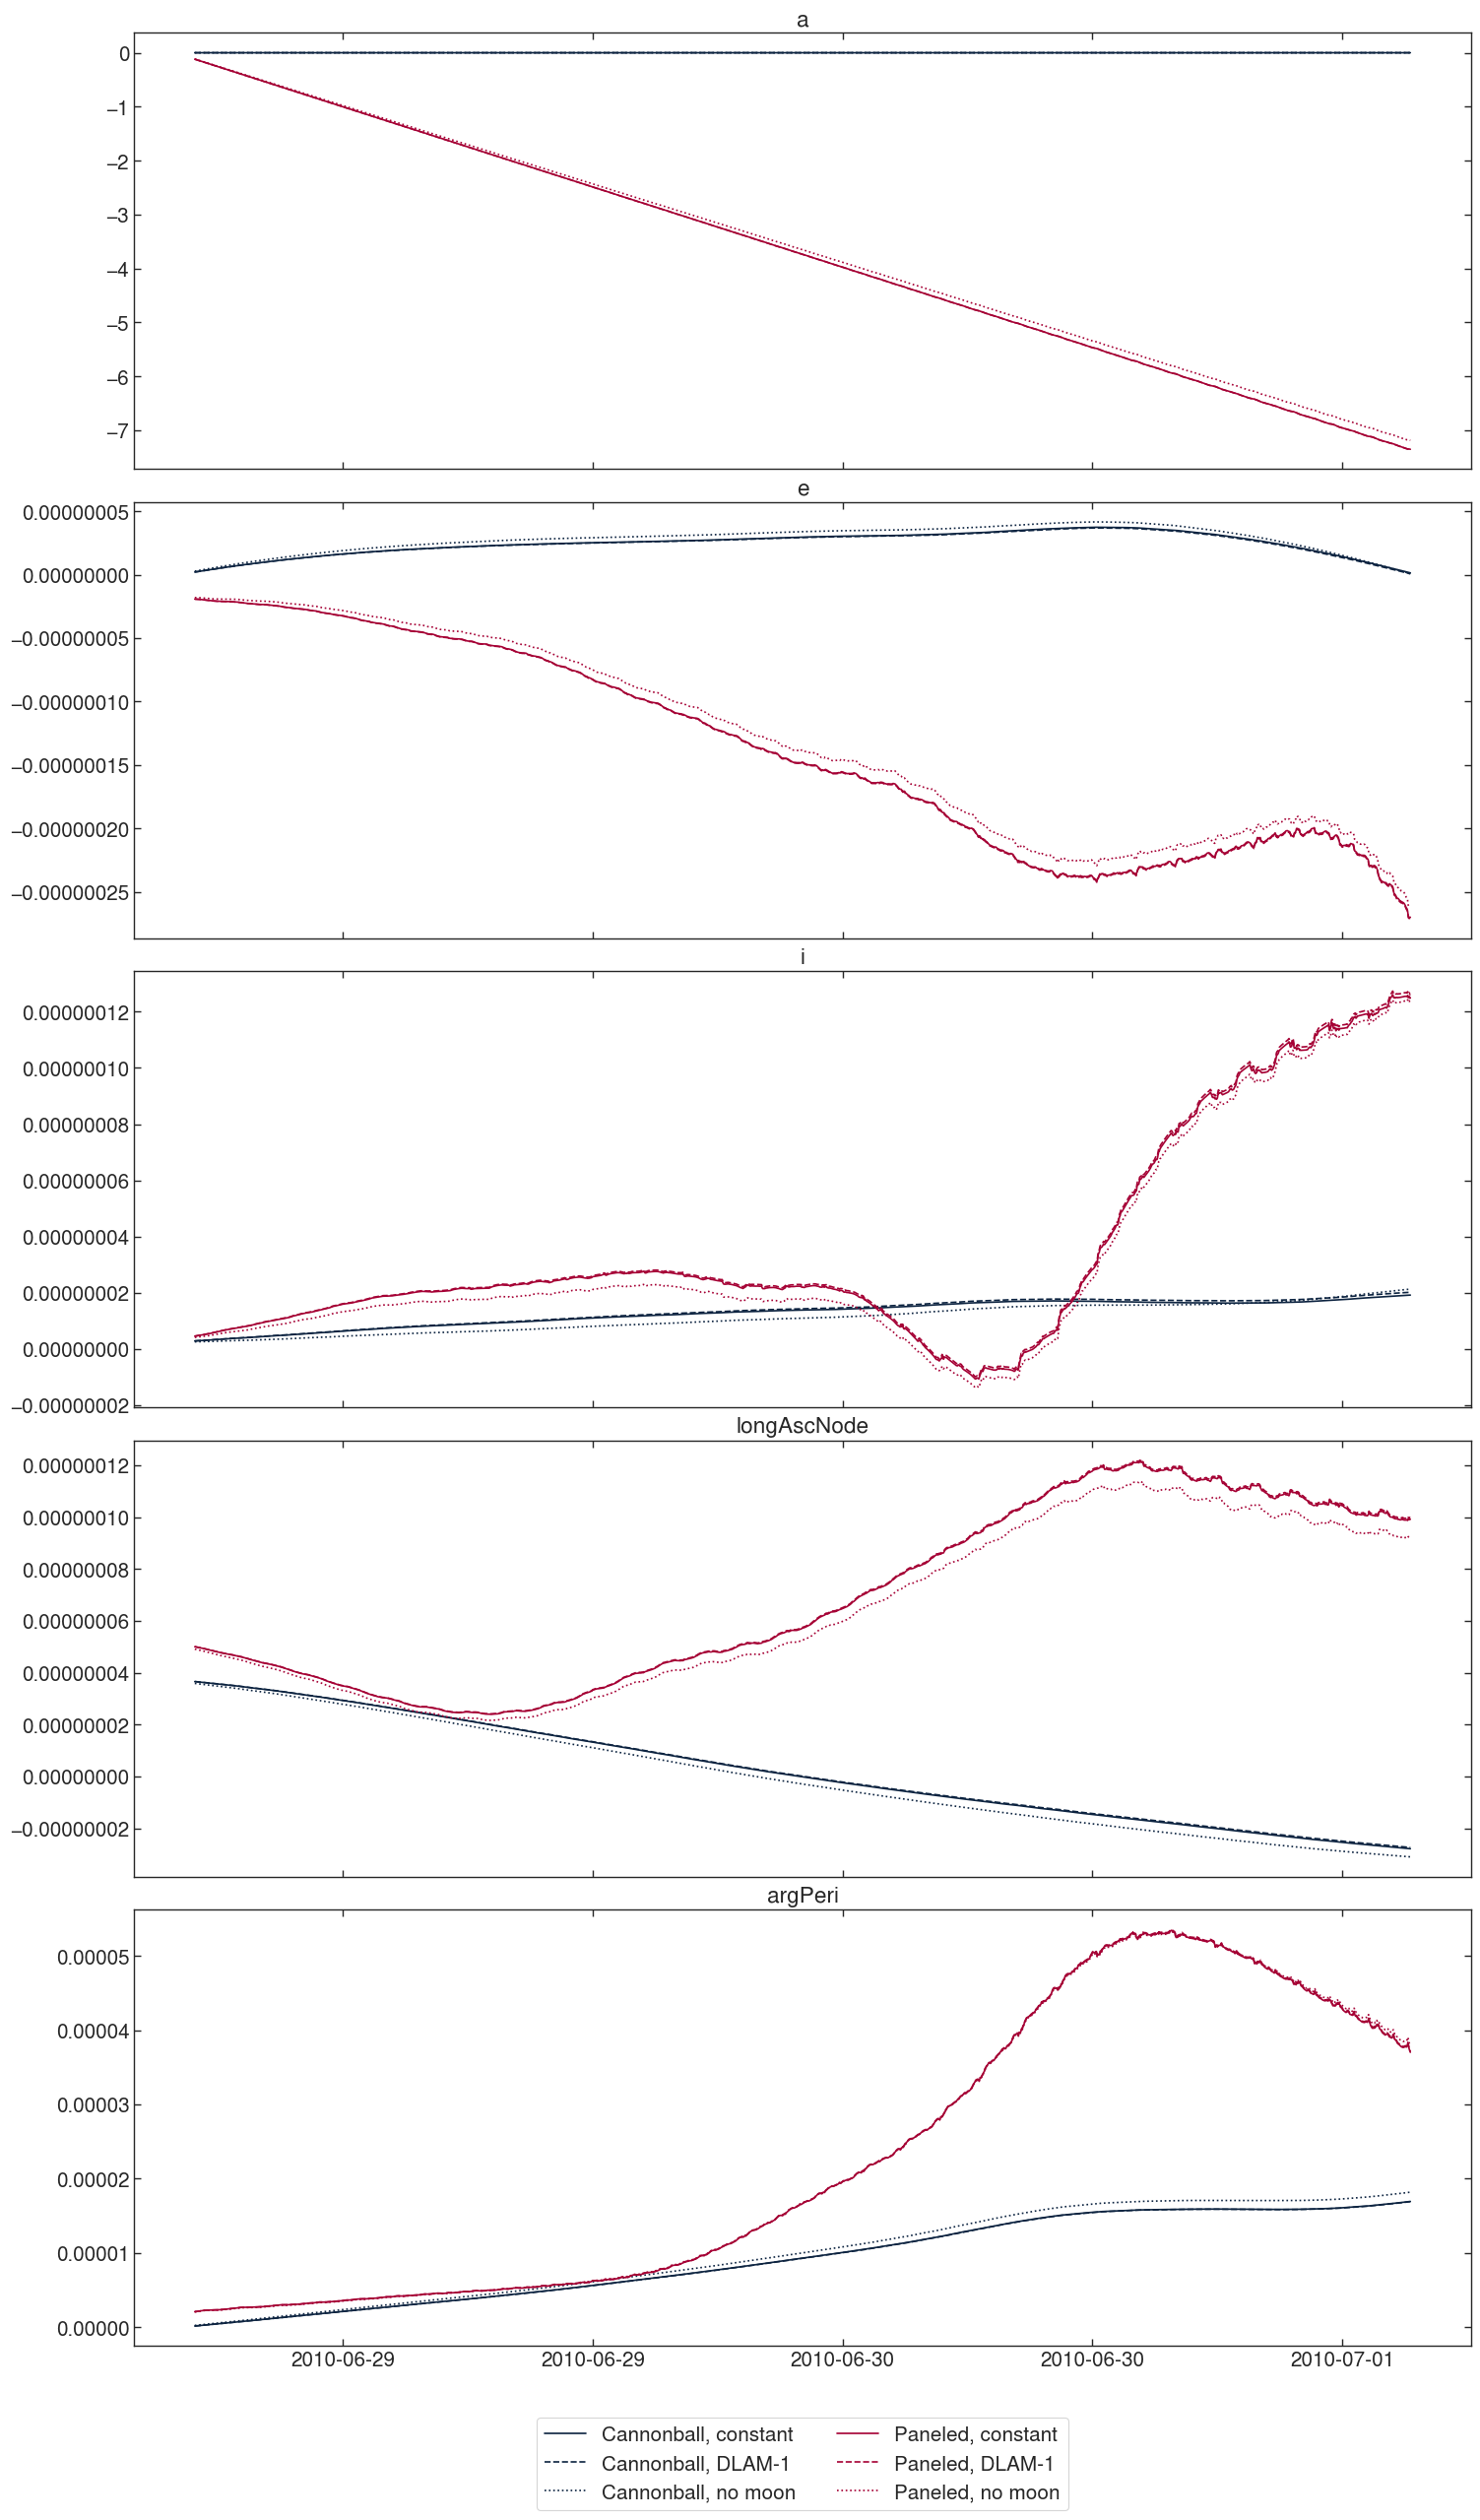

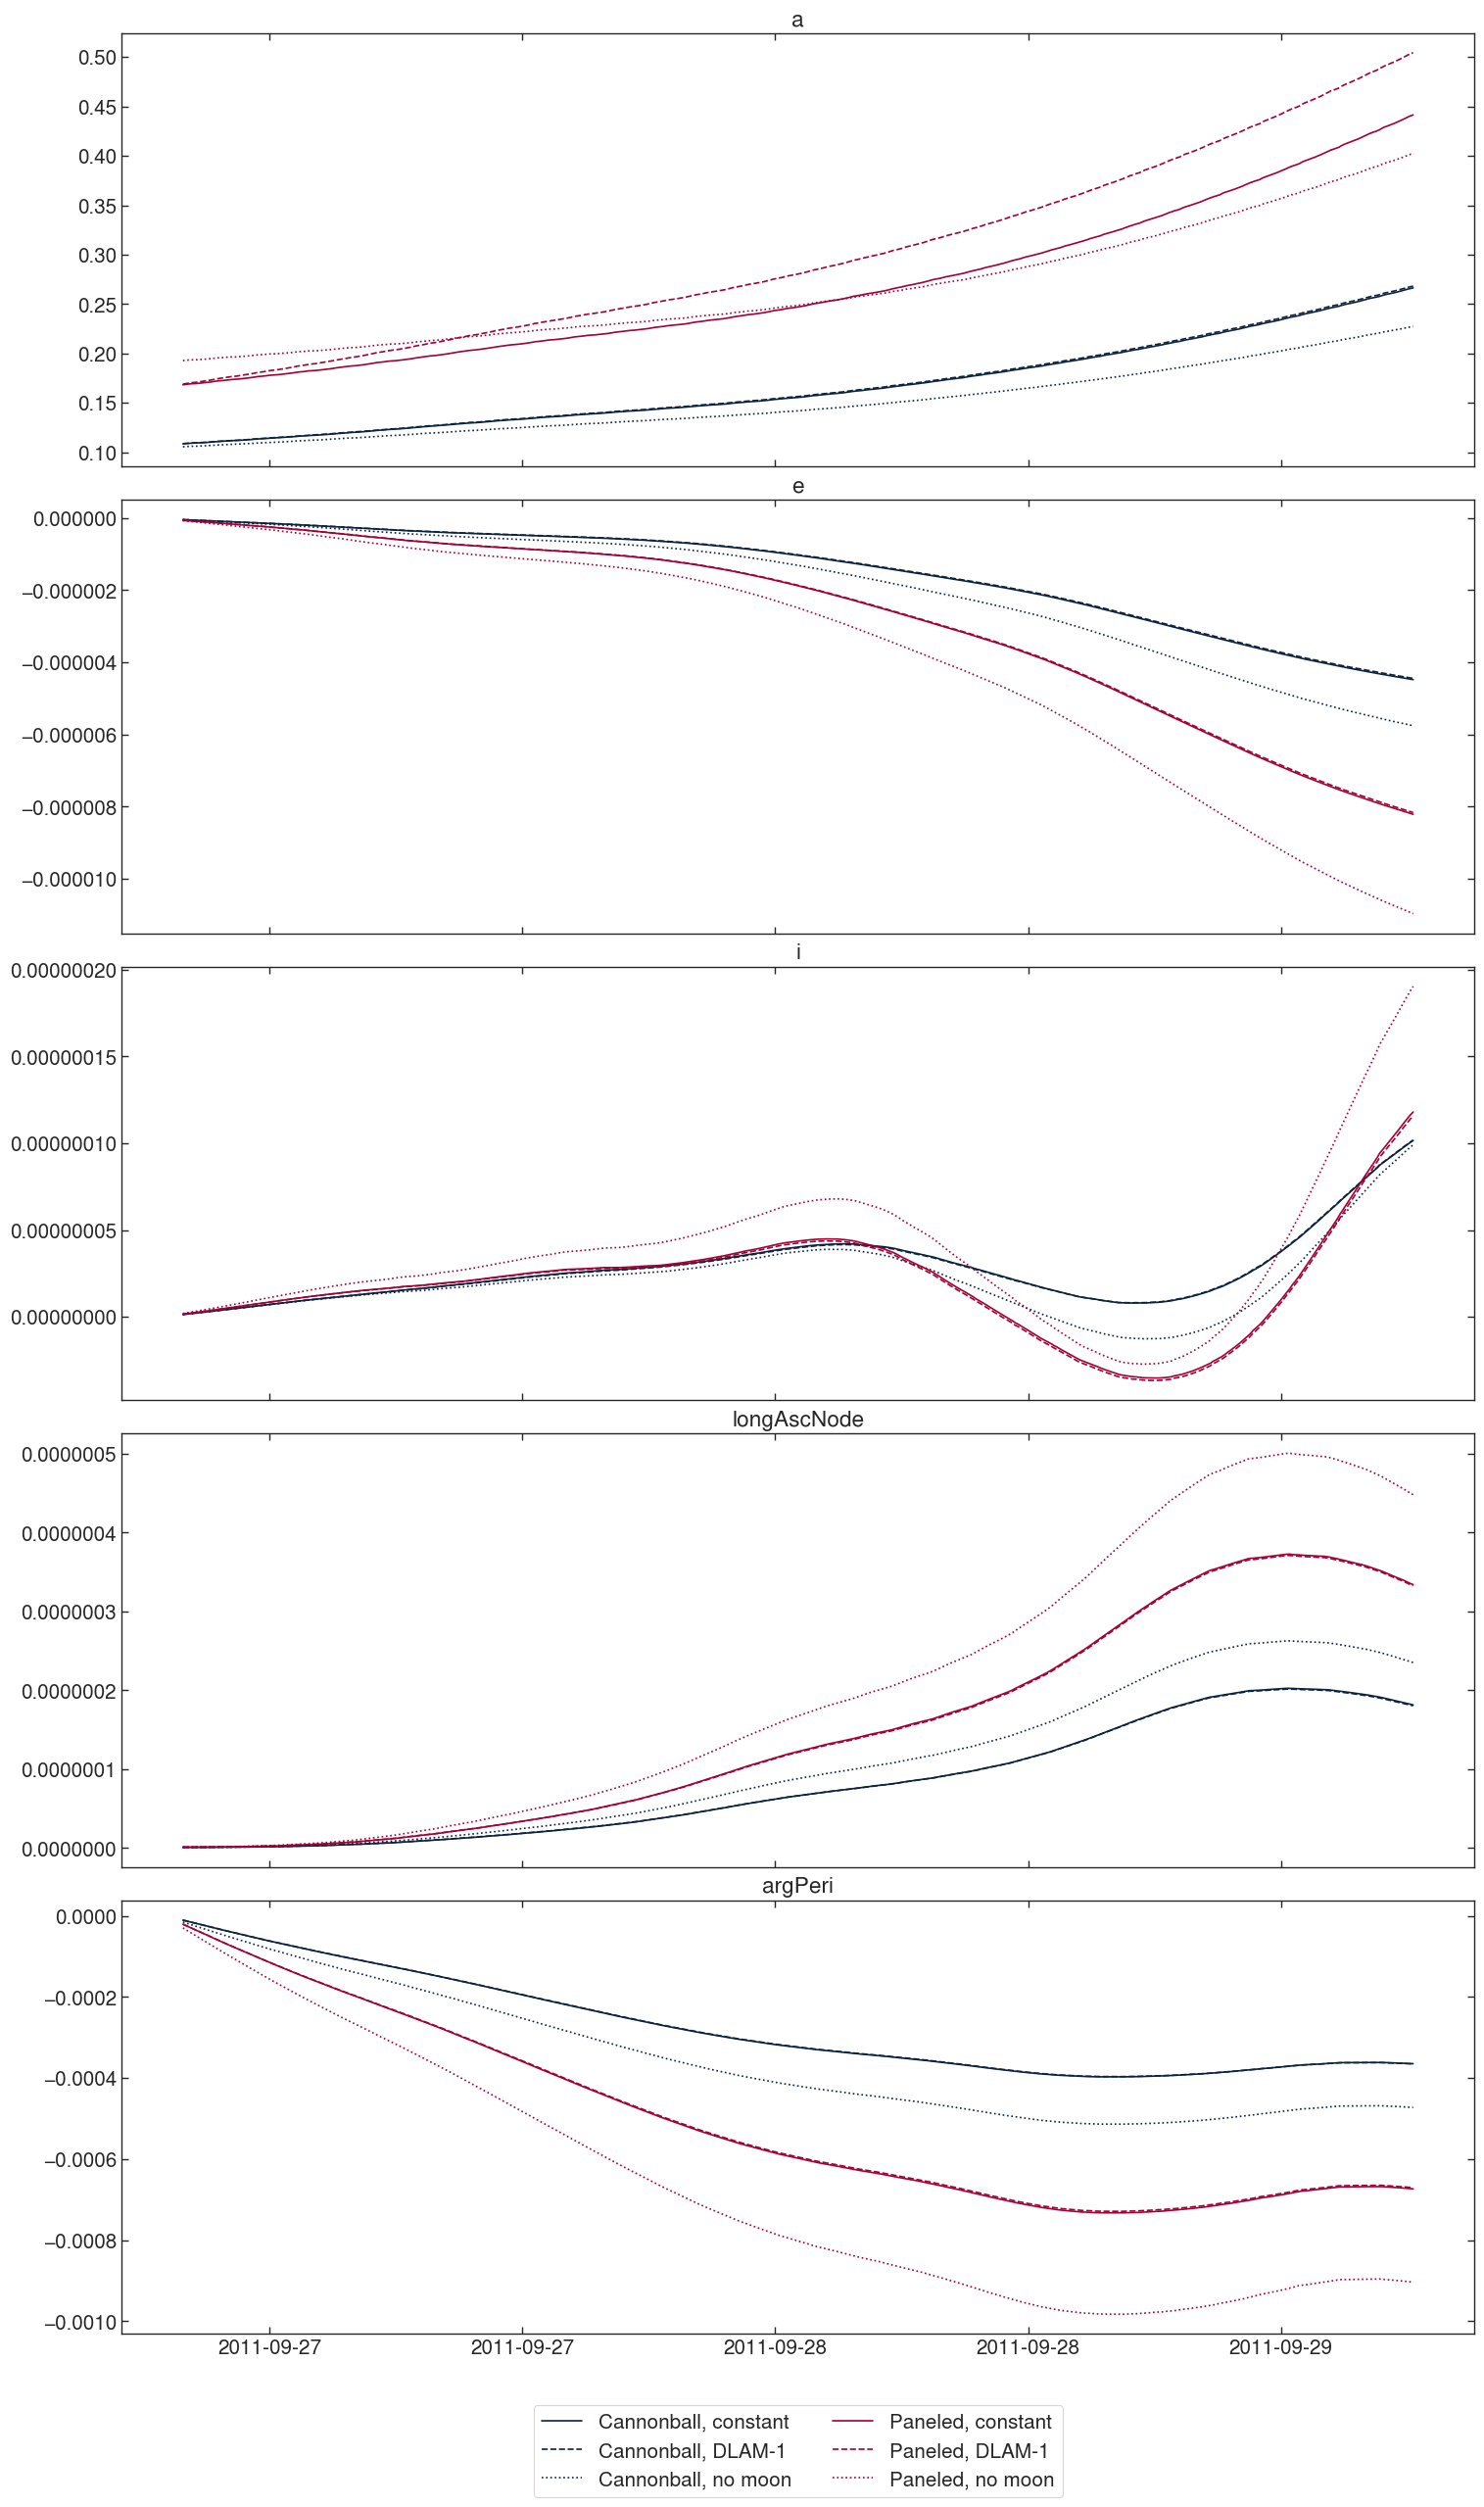

In [110]:
def plot_kepler_elements(start_date, mean=False, percent=False):
    fig, axs = plt.subplots(5, figsize=(15, 5*5), sharex="all")

    names = ["a", "e", "i", "longAscNode", "argPeri"]

    df_baseline = get_baseline(start_date)

    for i, (target_type, albedo_distribution_moon) in enumerate(itertools.product(["Cannonball", "Paneled"], ["constant", "DLAM-1", None])):
        if albedo_distribution_moon is None:
            run = get_run(start_date, True, False, target_type, "", True)
        else:
            run = get_run(start_date, True, True, target_type, albedo_distribution_moon, True)

        color = f"C{int(target_type == 'Paneled')}"
        ls = {
            "constant": "-",
            "DLAM-1": "--",
            None: ":"
        }[albedo_distribution_moon]

        for ax, name in zip(axs, names):
            y = run[f"kepler_{name}"] - df_baseline[f"kepler_{name}"]
            if percent:
                y *= 100 / df_baseline[f"kepler_{name}"]
                y = y[y < 100]
            else:
                y = y[y / df_baseline[f"kepler_{name}"] < 1]
            if mean:
                y = y.rolling(orbit_steps).mean()
            ax.plot(y.index, y, label=f"{target_type}, {albedo_distribution_moon or 'no moon'}", color=color, ls=ls)
    
    axs[-1].legend(bbox_to_anchor =(0.5,-0.4), loc="lower center", ncol=2)
    for ax, name in zip(axs, names):
        ax.set_title(name)
        ax.ticklabel_format(axis="y", style="plain")

    # axs[-1].set_xlim([dt(2010, 9, 27, 6), dt(2010, 9, 27, 6) + timedelta(minutes=3*113)])
    
    format_plot()

# plot_kepler_elements("2010 JUN 28", mean=False, percent=False)
plot_kepler_elements("2010 JUN 28", mean=True, percent=False)
plot_kepler_elements("2011 SEP 26", mean=True, percent=False)

June (beta = 90):
* Largest change in inclination

September (beta = 0):
* Largest changes in eccentricity and semi major axis